In [1]:
# Install required packages.
import os

#!pip install torch==1.7.0
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install git+https://github.com/rusty1s/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 15.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/rusty1s/pytorch_geometric.git to /tmp/pip-req-build-vkpprn61
  Running command git clone --filter=blob:none --quiet https://github.com/rusty1s/pytorch_geometric.git /tmp/pip-req-build-vkpprn61
  Resolved https://github.com/rusty1s/pytorch_geometric.git to commit 845c5cffc086c0a37dd3255d5f9219d982439efe
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import argparse
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from math import sqrt

from torch_geometric.datasets import TUDataset

import torch as th
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear
from sklearn import metrics
from scipy.spatial.distance import hamming
import statistics
import pandas
from time import perf_counter
from IPython.core.display import deepcopy
from torch_geometric.nn import MessagePassing
import copy
from torch.nn import ReLU, Sequential
import pandas
import csv
from statistics import mean
from torch_geometric.data import Data


from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
import torch_geometric.nn as gnn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

Processing...
Done!


In [5]:
Explainability_name = 'PGExplainer'
Task_name = 'Graph Classification'
Model_Name = "GIN"
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6
classifier_bias = True
DataSet_name = "MUTAG"

File_Name = Model_Name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

In [6]:
#train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=0, shuffle=True)
#print("Number of Training Graphs: ", len(train_dataset))
#print("Number of Test Graphs: ", len(test_dataset))

df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
    read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
    read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

train_dataset = []
test_dataset = []
for index in read_training_list_indexes:
    train_dataset.append(dataset[index])
for index in read_test_list_indexes:
    test_dataset.append(dataset[index])


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]
Number of training graphs: 150
Number of test graphs: 38


In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [8]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)
#import GCN_plus_GAP as Graph_Network
#GNN_Model = Graph_Network.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph', input_dim=7, hidden_dim=7, output_dim=2, num_hid_layers=2, Bias=classifier_bias, act_fun='eLu', Weight_Initializer=1, dropout_rate=classifier_dropout)

#import DGCNN as dgcnn_model
#GNN_Model = dgcnn_model.DGCNN_Model(GNN_layers=[32, 32, 32, 7], num_classes=2, mlp_act_fun='ReLu', dgcnn_act_fun='tanh', mlp_dropout_rate=0.5, Weight_Initializer=3, Bias=False, dgcnn_k=20, node_feat_size=7, hid_channels=[16,32], conv1d_kernels=[2,5], ffn_layer_size=128, strides=[2,1])

import GIN as gin_model
GNN_Model = gin_model.GIN_Model(num_mlp_layers=4, Bias=classifier_bias, num_slp_layers=2, mlp_input_dim=7, mlp_hid_dim=7,
                                mlp_output_dim=2, mlp_act_fun="ReLu", dropout_rate=classifier_dropout,
                                Weight_Initializer=3, joint_embeddings=False)

In [9]:
print(GNN_Model)

GIN_Model(
  (gin_mlp_layers): ModuleList(
    (0-3): 4 x GIN_MLPs(
      (gin_mlp_layers): ModuleList(
        (0-1): 2 x Linear(in_features=7, out_features=7, bias=True)
      )
      (gin_batch_normalization): ModuleList(
        (0-1): 2 x BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (global_summing): GlobalSUMPool()
  (the_first_layer): Linear(in_features=7, out_features=7, bias=True)
  (lin1): Linear(in_features=7, out_features=7, bias=True)
  (lin2): Linear(in_features=7, out_features=2, bias=True)
  (dorpout): Dropout(p=0.1, inplace=False)
)


In [10]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [11]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch


In [12]:
def visualize_losses(GNN_Model_losses, epoch_history):
    GNN_Model_losses_list = torch.stack(GNN_Model_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(" Loss in Epoch: " + str(epoch_history))

    ax.plot(GNN_Model_losses_list, color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()


In [13]:
def train_step():
    GNN_Model_loss_batch = []
    Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in train_dataloader:

        #Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
        #batch_loss = loss_calculations(soft, batch_of_graphs.y)
        #Pred_Labels.extend(soft.argmax(dim=1).detach().tolist())

        #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch_of_graphs)
        #batch_loss = loss_calculations(softmaxed_h2, batch_of_graphs.y)
        #Pred_Labels.extend(softmaxed_h2.argmax(dim=1).detach().tolist())

        mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, lin2_output_softmaxed = GNN_Model(batch_of_graphs, None)
        batch_loss = loss_calculations(lin2_output_softmaxed, batch_of_graphs.y)
        Pred_Labels.extend(lin2_output_softmaxed.argmax(dim=1).detach().tolist())


        Real_Labels.extend(batch_of_graphs.y.detach().tolist())
        GNN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        GNN_Model_Optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, Pred_Labels)

In [14]:
GNN_Model_training_Acc_per_epoch = []
GNN_Model_training_time_per_epoch = []
def train(EPOCHS, load_index):
    GNN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        t1 = perf_counter()
        GNN_Model_training_loss, training_acc = train_step()
        GNN_Model_training_time_per_epoch.append(perf_counter()-t1)
        print(f'Epoch: {epoch+1:03d}, Model Loss: {GNN_Model_training_loss:.4f}')

        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)
        GNN_Model_training_Acc_per_epoch.append(training_acc)
        #break

        if (epoch + load_index + 1) % 50 == 0 and epoch > 0:
            visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        if (epoch + load_index + 1) % 100 == 0 and epoch > 0:
            torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")



Epoch: 001, Model Loss: 0.6265
Epoch: 002, Model Loss: 0.5955
Epoch: 003, Model Loss: 0.5775
Epoch: 004, Model Loss: 0.5676
Epoch: 005, Model Loss: 0.5619
Epoch: 006, Model Loss: 0.5505
Epoch: 007, Model Loss: 0.5371
Epoch: 008, Model Loss: 0.5304
Epoch: 009, Model Loss: 0.5192
Epoch: 010, Model Loss: 0.5112
Epoch: 011, Model Loss: 0.5035
Epoch: 012, Model Loss: 0.5094
Epoch: 013, Model Loss: 0.5023
Epoch: 014, Model Loss: 0.4967
Epoch: 015, Model Loss: 0.4916
Epoch: 016, Model Loss: 0.4879
Epoch: 017, Model Loss: 0.4895
Epoch: 018, Model Loss: 0.4794
Epoch: 019, Model Loss: 0.4732
Epoch: 020, Model Loss: 0.4756
Epoch: 021, Model Loss: 0.4731
Epoch: 022, Model Loss: 0.4670
Epoch: 023, Model Loss: 0.4683
Epoch: 024, Model Loss: 0.4662
Epoch: 025, Model Loss: 0.4645
Epoch: 026, Model Loss: 0.4637
Epoch: 027, Model Loss: 0.4595
Epoch: 028, Model Loss: 0.4595
Epoch: 029, Model Loss: 0.4615
Epoch: 030, Model Loss: 0.4660
Epoch: 031, Model Loss: 0.4581
Epoch: 032, Model Loss: 0.4616
Epoch: 0

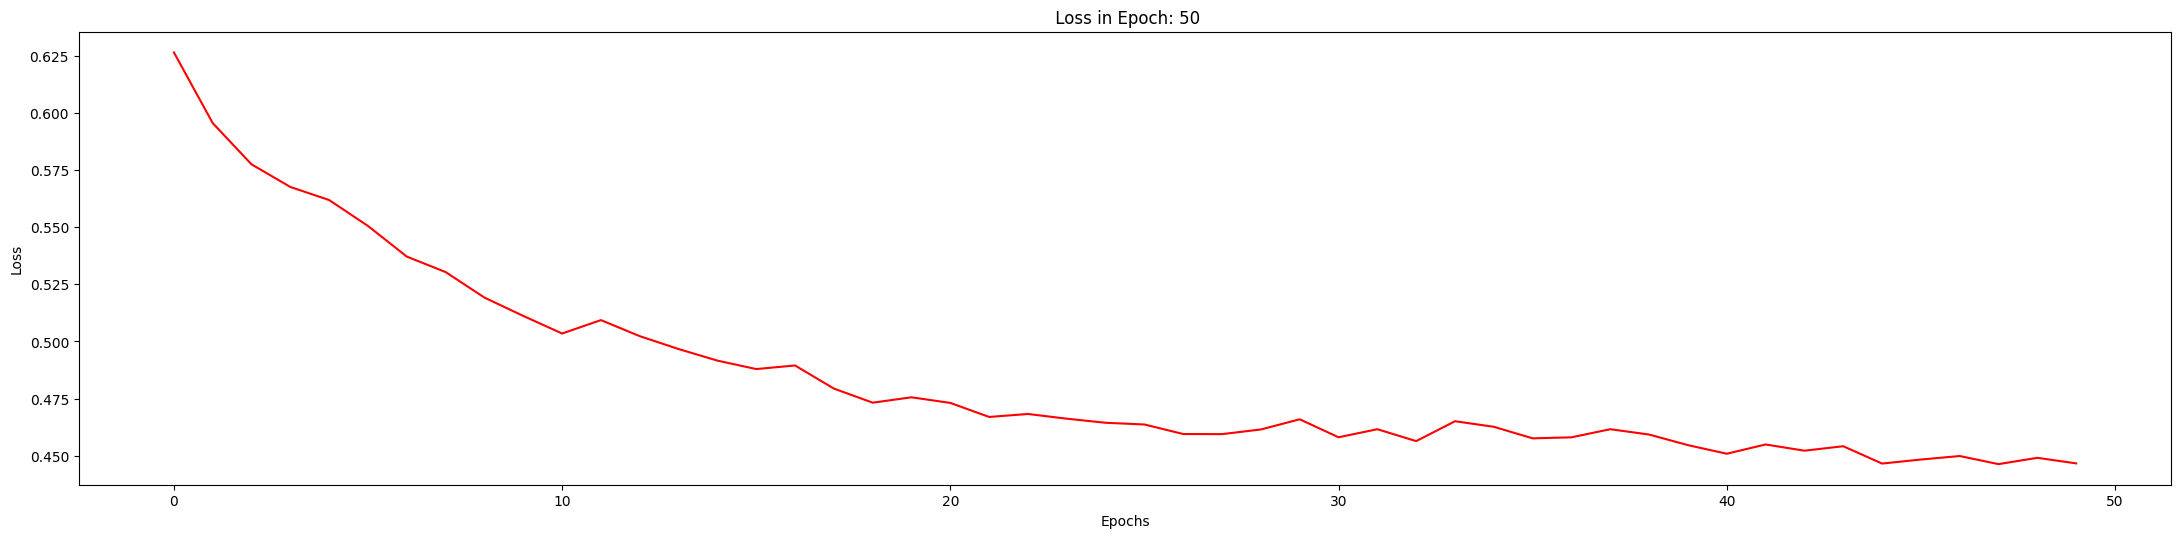

Epoch: 051, Model Loss: 0.4421
Epoch: 052, Model Loss: 0.4406
Epoch: 053, Model Loss: 0.4441
Epoch: 054, Model Loss: 0.4475
Epoch: 055, Model Loss: 0.4396
Epoch: 056, Model Loss: 0.4389
Epoch: 057, Model Loss: 0.4361
Epoch: 058, Model Loss: 0.4373
Epoch: 059, Model Loss: 0.4372
Epoch: 060, Model Loss: 0.4359
Epoch: 061, Model Loss: 0.4328
Epoch: 062, Model Loss: 0.4375
Epoch: 063, Model Loss: 0.4329
Epoch: 064, Model Loss: 0.4328
Epoch: 065, Model Loss: 0.4332
Epoch: 066, Model Loss: 0.4293
Epoch: 067, Model Loss: 0.4309
Epoch: 068, Model Loss: 0.4294
Epoch: 069, Model Loss: 0.4266
Epoch: 070, Model Loss: 0.4254
Epoch: 071, Model Loss: 0.4411
Epoch: 072, Model Loss: 0.4362
Epoch: 073, Model Loss: 0.4414
Epoch: 074, Model Loss: 0.4430
Epoch: 075, Model Loss: 0.4386
Epoch: 076, Model Loss: 0.4350
Epoch: 077, Model Loss: 0.4319
Epoch: 078, Model Loss: 0.4397
Epoch: 079, Model Loss: 0.4341
Epoch: 080, Model Loss: 0.4332
Epoch: 081, Model Loss: 0.4311
Epoch: 082, Model Loss: 0.4296
Epoch: 0

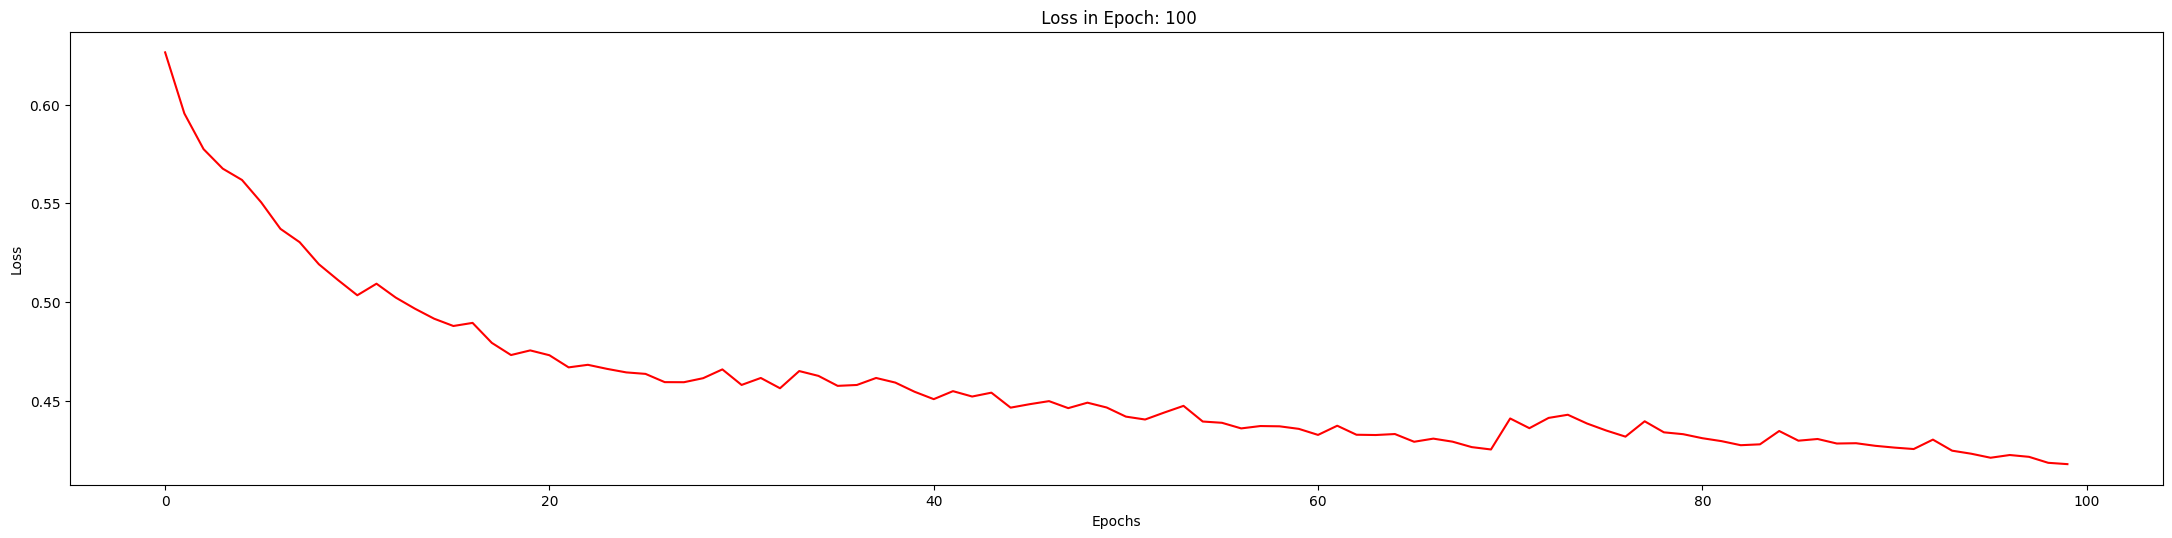

Epoch: 101, Model Loss: 0.4198
Epoch: 102, Model Loss: 0.4179
Epoch: 103, Model Loss: 0.4159
Epoch: 104, Model Loss: 0.4144
Epoch: 105, Model Loss: 0.4167
Epoch: 106, Model Loss: 0.4137
Epoch: 107, Model Loss: 0.4138
Epoch: 108, Model Loss: 0.4130
Epoch: 109, Model Loss: 0.4166
Epoch: 110, Model Loss: 0.4154
Epoch: 111, Model Loss: 0.4108
Epoch: 112, Model Loss: 0.4144
Epoch: 113, Model Loss: 0.4149
Epoch: 114, Model Loss: 0.4194
Epoch: 115, Model Loss: 0.4144
Epoch: 116, Model Loss: 0.4115
Epoch: 117, Model Loss: 0.4122
Epoch: 118, Model Loss: 0.4083
Epoch: 119, Model Loss: 0.4101
Epoch: 120, Model Loss: 0.4083
Epoch: 121, Model Loss: 0.4087
Epoch: 122, Model Loss: 0.4107
Epoch: 123, Model Loss: 0.4094
Epoch: 124, Model Loss: 0.4102
Epoch: 125, Model Loss: 0.4089
Epoch: 126, Model Loss: 0.4092
Epoch: 127, Model Loss: 0.4095
Epoch: 128, Model Loss: 0.4060
Epoch: 129, Model Loss: 0.4054
Epoch: 130, Model Loss: 0.4092
Epoch: 131, Model Loss: 0.4068
Epoch: 132, Model Loss: 0.4066
Epoch: 1

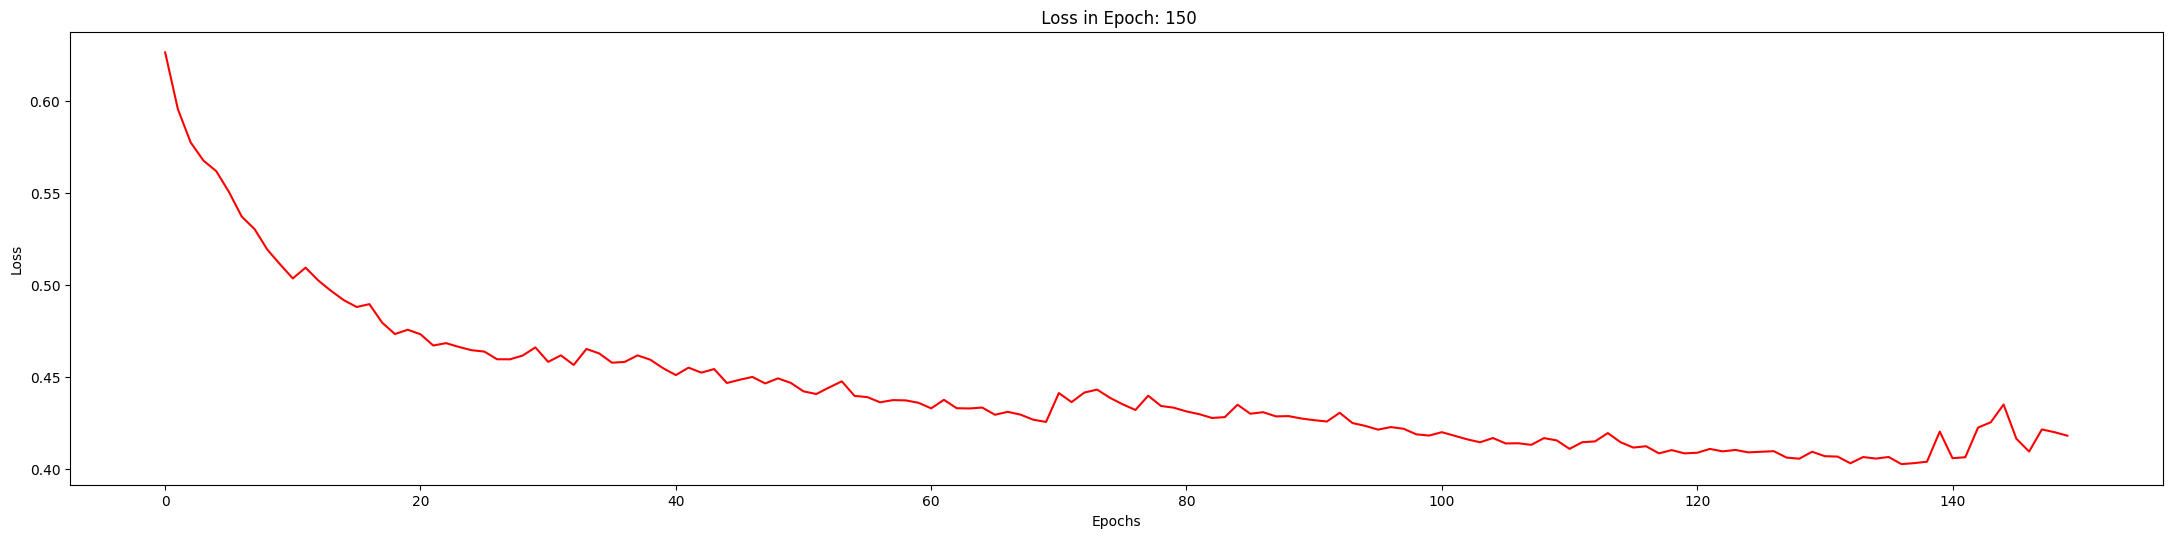

Epoch: 151, Model Loss: 0.4141
Epoch: 152, Model Loss: 0.4106
Epoch: 153, Model Loss: 0.4129
Epoch: 154, Model Loss: 0.4078
Epoch: 155, Model Loss: 0.4056
Epoch: 156, Model Loss: 0.4055
Epoch: 157, Model Loss: 0.4102
Epoch: 158, Model Loss: 0.4056
Epoch: 159, Model Loss: 0.4062
Epoch: 160, Model Loss: 0.4058
Epoch: 161, Model Loss: 0.4053
Epoch: 162, Model Loss: 0.4018
Epoch: 163, Model Loss: 0.4047
Epoch: 164, Model Loss: 0.4023
Epoch: 165, Model Loss: 0.4036
Epoch: 166, Model Loss: 0.4030
Epoch: 167, Model Loss: 0.3987
Epoch: 168, Model Loss: 0.4045
Epoch: 169, Model Loss: 0.4020
Epoch: 170, Model Loss: 0.3971
Epoch: 171, Model Loss: 0.3975
Epoch: 172, Model Loss: 0.3983
Epoch: 173, Model Loss: 0.4020
Epoch: 174, Model Loss: 0.3967
Epoch: 175, Model Loss: 0.3992
Epoch: 176, Model Loss: 0.3939
Epoch: 177, Model Loss: 0.3959
Epoch: 178, Model Loss: 0.3984
Epoch: 179, Model Loss: 0.3955
Epoch: 180, Model Loss: 0.3928
Epoch: 181, Model Loss: 0.3926
Epoch: 182, Model Loss: 0.3933
Epoch: 1

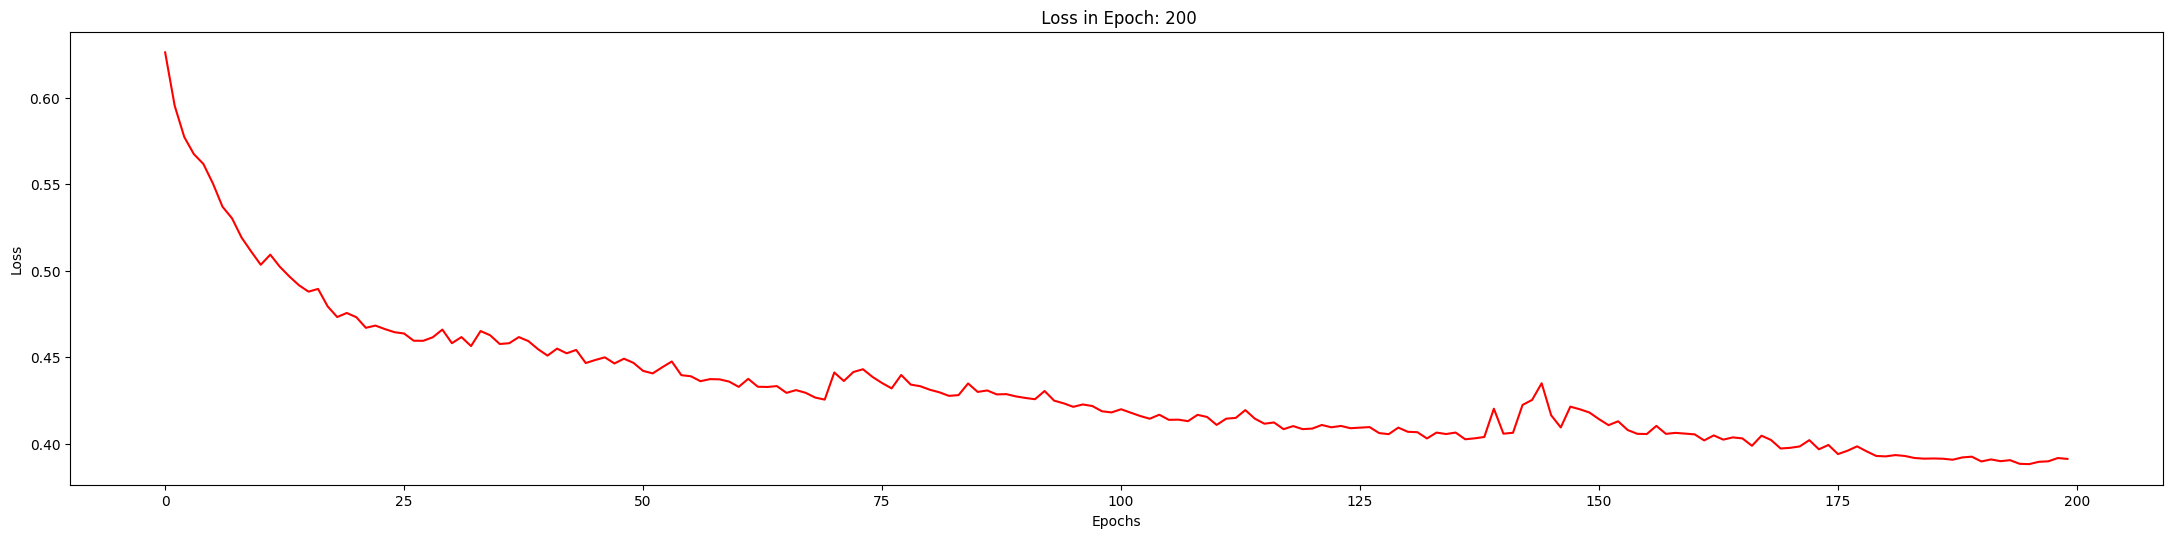

Epoch: 201, Model Loss: 0.3913
Epoch: 202, Model Loss: 0.3880
Epoch: 203, Model Loss: 0.3877
Epoch: 204, Model Loss: 0.3904
Epoch: 205, Model Loss: 0.3877
Epoch: 206, Model Loss: 0.3868
Epoch: 207, Model Loss: 0.3899
Epoch: 208, Model Loss: 0.3858
Epoch: 209, Model Loss: 0.3855
Epoch: 210, Model Loss: 0.3857
Epoch: 211, Model Loss: 0.3860
Epoch: 212, Model Loss: 0.3882
Epoch: 213, Model Loss: 0.3861
Epoch: 214, Model Loss: 0.3886
Epoch: 215, Model Loss: 0.3861
Epoch: 216, Model Loss: 0.3847
Epoch: 217, Model Loss: 0.3851
Epoch: 218, Model Loss: 0.3837
Epoch: 219, Model Loss: 0.3838
Epoch: 220, Model Loss: 0.3841
Epoch: 221, Model Loss: 0.3835
Epoch: 222, Model Loss: 0.3842
Epoch: 223, Model Loss: 0.3830
Epoch: 224, Model Loss: 0.3834
Epoch: 225, Model Loss: 0.3833
Epoch: 226, Model Loss: 0.3824
Epoch: 227, Model Loss: 0.3823
Epoch: 228, Model Loss: 0.3824
Epoch: 229, Model Loss: 0.3822
Epoch: 230, Model Loss: 0.3816
Epoch: 231, Model Loss: 0.3817
Epoch: 232, Model Loss: 0.3847
Epoch: 2

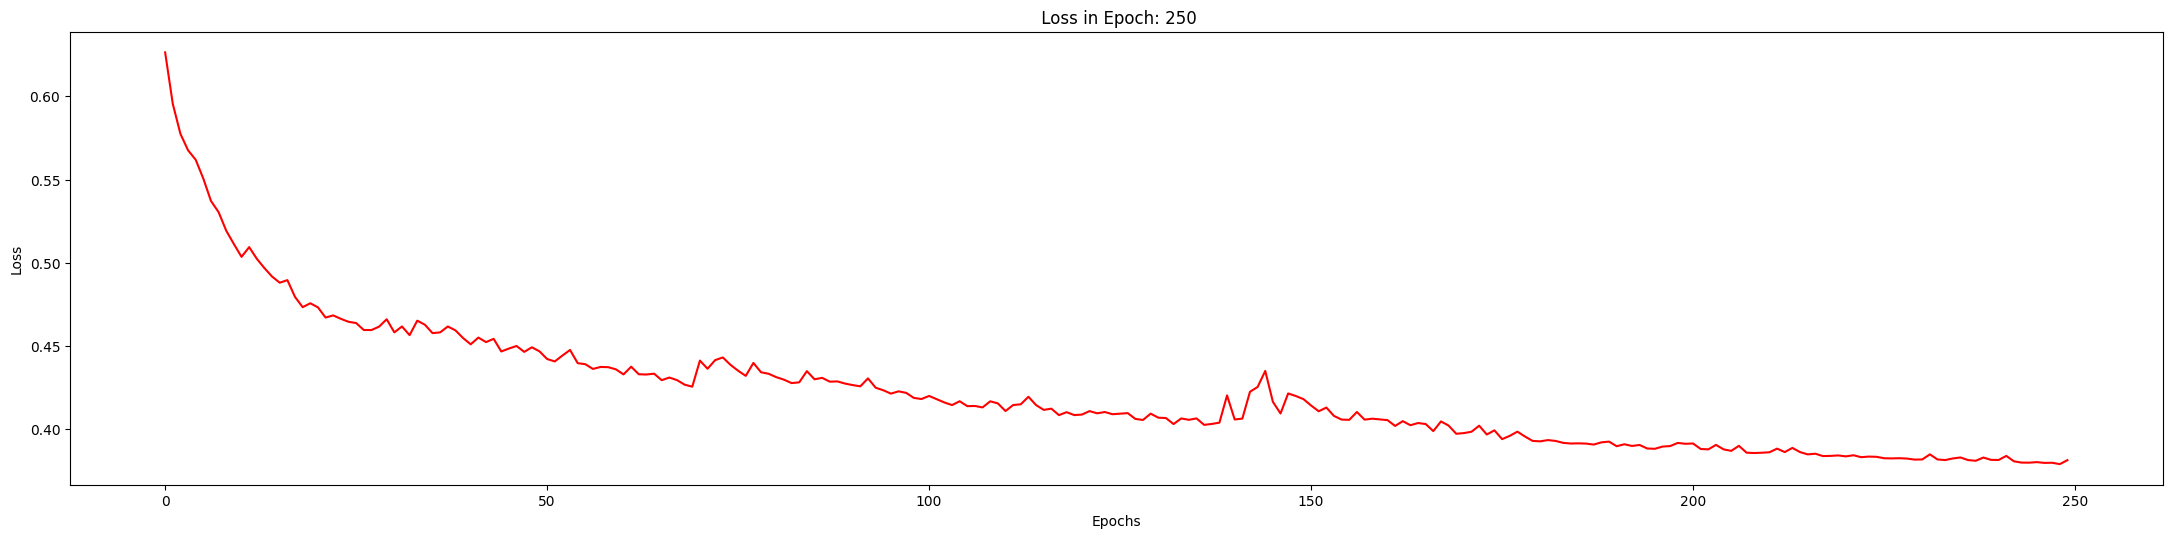

Epoch: 251, Model Loss: 0.3789
Epoch: 252, Model Loss: 0.3784
Epoch: 253, Model Loss: 0.3802
Epoch: 254, Model Loss: 0.3797
Epoch: 255, Model Loss: 0.3780
Epoch: 256, Model Loss: 0.3828
Epoch: 257, Model Loss: 0.3782
Epoch: 258, Model Loss: 0.3775
Epoch: 259, Model Loss: 0.3778
Epoch: 260, Model Loss: 0.3775
Epoch: 261, Model Loss: 0.3777
Epoch: 262, Model Loss: 0.3776
Epoch: 263, Model Loss: 0.3771
Epoch: 264, Model Loss: 0.3768
Epoch: 265, Model Loss: 0.3769
Epoch: 266, Model Loss: 0.3767
Epoch: 267, Model Loss: 0.3766
Epoch: 268, Model Loss: 0.3766
Epoch: 269, Model Loss: 0.3762
Epoch: 270, Model Loss: 0.3801
Epoch: 271, Model Loss: 0.3759
Epoch: 272, Model Loss: 0.3758
Epoch: 273, Model Loss: 0.3756
Epoch: 274, Model Loss: 0.3754
Epoch: 275, Model Loss: 0.3753
Epoch: 276, Model Loss: 0.3755
Epoch: 277, Model Loss: 0.3751
Epoch: 278, Model Loss: 0.3750
Epoch: 279, Model Loss: 0.3754
Epoch: 280, Model Loss: 0.3747
Epoch: 281, Model Loss: 0.3748
Epoch: 282, Model Loss: 0.3747
Epoch: 2

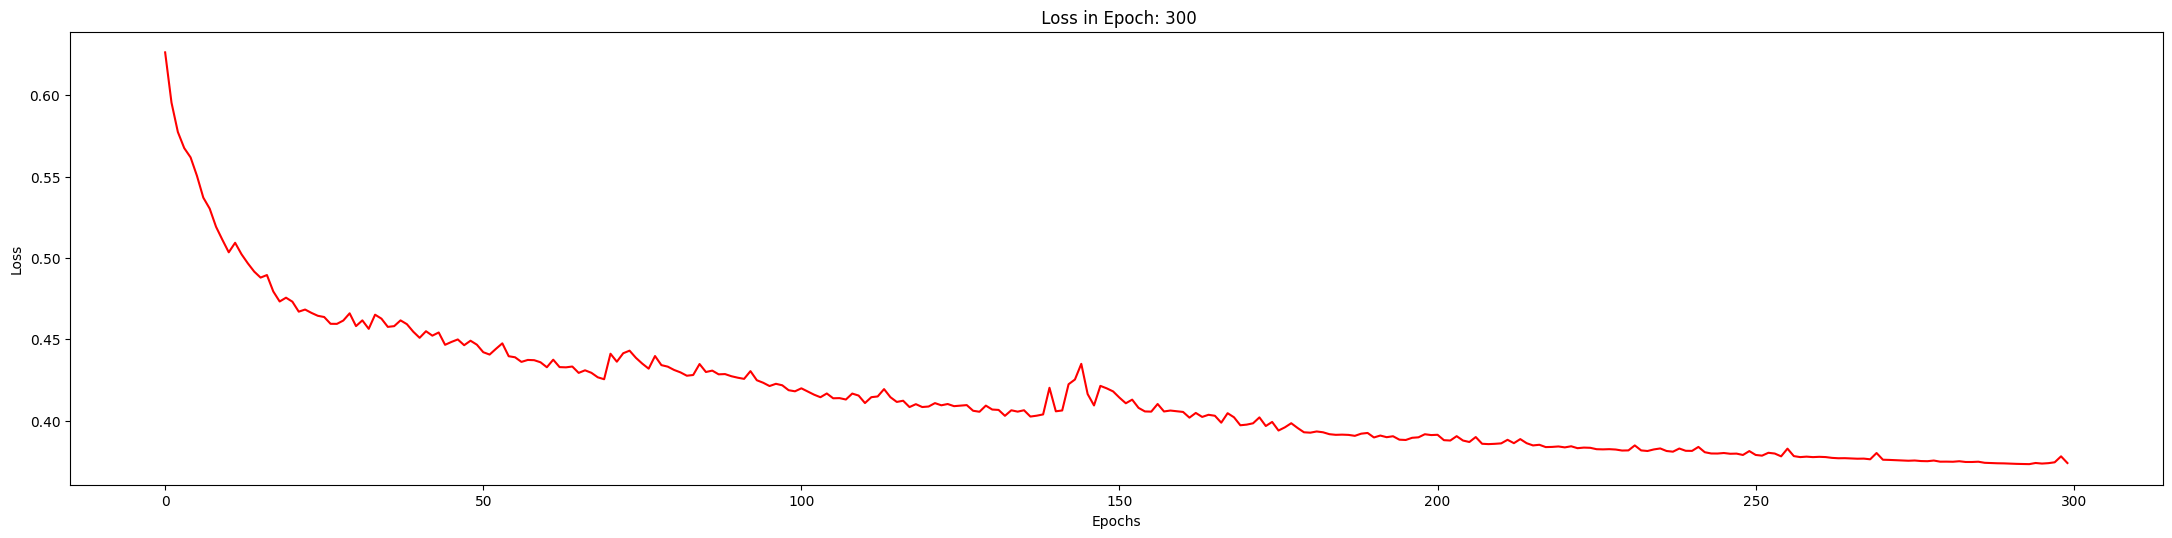

In [15]:
EPOCHS = 300
load_index = 0

train(EPOCHS, load_index)

In [16]:
GNN_Model_test_predicted_labels = []
def GNN_Model_test(test_loader):
    GNN_Model.eval()
    correct = 0
    for batch_of_graphs in test_loader:
        mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, lin2_output_softmaxed = GNN_Model(batch_of_graphs, None)
        GNN_Model_test_pred = lin2_output_softmaxed.argmax(dim=1).tolist()[0]

        GNN_Model_test_predicted_labels.append(GNN_Model_test_pred)
        correct += int((GNN_Model_test_pred == batch_of_graphs.y).sum())

    return correct / len(test_loader.dataset), GNN_Model_test_predicted_labels

In [17]:
GNN_Model_test_acc, predicted_labels = GNN_Model_test(test_dataloader)
print(f'Test Accuracy: {GNN_Model_test_acc:.4f}')

Test Accuracy: 0.6842


In [ ]:
print(GNN_Model)
test_dataloader_example = DataLoader(test_dataset, batch_size=1, shuffle=False)
for batch in test_dataloader_example:
    #Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch)
    #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch)
    mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, lin2_output_softmaxed = GNN_Model(batch, None)
    break
#print(soft)
#print(softmaxed_h2)
#print(train_dataset[0].x)
print(lin2_output_softmaxed)

GIN_Model(
  (gin_mlp_layers): ModuleList(
    (0-3): 4 x GIN_MLPs(
      (gin_mlp_layers): ModuleList(
        (0-1): 2 x Linear(in_features=7, out_features=7, bias=True)
      )
      (gin_batch_normalization): ModuleList(
        (0-1): 2 x BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (global_summing): GlobalSUMPool()
  (lin1): Linear(in_features=35, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=2, bias=True)
  (dorpout): Dropout(p=0.1, inplace=False)
)
tensor([[0.9977, 0.0023]], grad_fn=<SoftmaxBackward0>)


In [ ]:
def instance_time(test_dataset):
    instance_based_time = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_dataset:
        start_generation = perf_counter()
        #Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        #GNN_test_pred = soft.argmax(dim=1)

        mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, lin2_output_softmaxed = GNN_Model(batched_data, None)
        GNN_test_pred = lin2_output_softmaxed.argmax(dim=1)

        consumed_time = perf_counter() - start_generation
        instance_based_time.append(consumed_time)
    return instance_based_time

In [ ]:
samples_time = instance_time(test_dataset)
print(f'Test Instance based Time: {samples_time}')

Test Instance based Time: [0.00550647300002538, 0.0038267259999997805, 0.0036147299999811366, 0.002665542000045207, 0.002540632000034293, 0.0024375739999982216, 0.0024332240000148886, 0.0024581159999570446, 0.00259284599997045, 0.002459543999975722, 0.00246292799999992, 0.00247918499997013, 0.002469769000015276, 0.0029614599999945312, 0.004303411000023516, 0.0027432539999949768, 0.0027018040000257315, 0.002518633999955, 0.0034845879999920726, 0.0036318749999963984, 0.0034007070000257045, 0.003568905999998151, 0.0036594790000208377, 0.003637034999997013, 0.0038039209999851664, 0.0035447430000203894, 0.0030502619999879244, 0.002617085999986557, 0.0025519240000448917, 0.0024458799999820258, 0.0024206570000160355, 0.002395525999986603, 0.002357029999984661, 0.002327101000048515, 0.0023267509999982394, 0.0023308510000106253, 0.002257790000044224, 0.002248382000004767]


In [ ]:
real_labels = []
for graph in test_dataloader:
    real_labels.append(graph.y.tolist()[0])

In [ ]:
print("predicted_labels: ", predicted_labels)
print("real_labels: ", real_labels)
print("Test Accuracy: ", metrics.accuracy_score(real_labels, predicted_labels))

predicted_labels:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
real_labels:  [1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]
Test Accuracy:  0.3684210526315789


In [ ]:
Auc_Roc = metrics.roc_auc_score(real_labels, predicted_labels)
precision, recall, thresholds = metrics.precision_recall_curve(real_labels, predicted_labels)
Auc_Prc = metrics.auc(y=precision, x=recall)
Acc = metrics.accuracy_score(real_labels, predicted_labels, normalize=True)
Acc2 = metrics.accuracy_score(real_labels, predicted_labels, normalize=False)
print("Auc_Roc: ", Auc_Roc, "Auc_Prc: ", Auc_Prc, "Acc: ", Acc, "Acc2: ", Acc2)

Auc_Roc:  0.48511904761904767 Auc_Prc:  0.5734649122807017 Acc:  0.3684210526315789 Acc2:  14


## **PGExplainer**

In [19]:

class PGExplainer:
    coeffs = {'edge_size': 0.05,
              'edge_ent': 1.0,
              'temp': [5.0, 2.0],
              'bias': 0.0,
              }
    def __init__(self, Model_Name, classifier_load_index, explainer_save_index, Exp_Epoch, Exp_lr, input_dim, hid_dim, output_dim):
        #self.GNN_Model = GNN_Model
        self.GNN_Model = self.load_model(Task_name=Task_name, Explainability_name=Explainability_name, Model_Name=Model_Name, classifier_load_index=classifier_load_index, input_dim=input_dim, hid_dim=hid_dim, output_dim=output_dim)
        self.input_dim = input_dim
        self.explainer_lr = Exp_lr
        self.pgexp_mlp = Sequential(Linear(self.input_dim * 2, 64), ReLU(), Linear(64, 1))
        self.pgexp_mlp_optimizer = torch.optim.Adam(self.pgexp_mlp.parameters(), lr=self.explainer_lr)
        self.explainer_epochs = Exp_Epoch
        #self.criterion = torch.nn.CrossEntropyLoss()
        self.criterion = F.binary_cross_entropy_with_logits
        self.explainer_save_index = explainer_save_index
        self.Explainability_name = 'PGExplainer'
        self.Task_name = 'Graph Classification'
        self.Model_Name = Model_Name

    def load_model(self, Task_name, Explainability_name, Model_Name, classifier_load_index, input_dim, hid_dim, output_dim):

        if classifier_load_index != 0:
            GNN_Model, optimizer, classifier_load_index = self.loading_config(Task_name=Task_name, Explainability_name=Explainability_name, Model_Name=Model_Name,
                                                                         classifier_load_index=classifier_load_index, input_dim=input_dim, hid_dim=hid_dim,
                                                                         output_dim=output_dim)
            return GNN_Model
        else:
            #GNN_Model = Graph_Network.GCN_plus_GAP(model_name=Model_Name, model_level='graph', input_dim=input_dim,
            #                                       hidden_dim=hid_dim, output_dim=output_dim, num_hid_layers=2,
            #                                       Bias=True, act_fun='eLu', Weight_Initializer=1, dropout_rate=0.1)
            GNN_Model = gin_model.GIN_Model(num_mlp_layers=4, Bias=classifier_bias, num_slp_layers=2, mlp_input_dim=7, mlp_hid_dim=7, mlp_output_dim=7,
                                            mlp_act_fun="ReLu", num_classes=2, dropout_rate=classifier_dropout, Weight_Initializer=3)
            return GNN_Model

    def loading_config(self, Task_name, Explainability_name, Model_Name, classifier_load_index, input_dim, hid_dim, output_dim):
        #GNN_Model = Graph_Network.GCN_plus_GAP(model_name=Model_Name, model_level='graph', input_dim=input_dim, hidden_dim=hid_dim, output_dim=output_dim, num_hid_layers=2, Bias=True, act_fun='eLu', Weight_Initializer=1, dropout_rate=0.1)
        GNN_Model = gin_model.GIN_Model(num_mlp_layers=4, Bias=classifier_bias, num_slp_layers=2, mlp_input_dim=7, mlp_hid_dim=7, mlp_output_dim=2,
                                        mlp_act_fun="ReLu", dropout_rate=classifier_dropout, Weight_Initializer=3, joint_embeddings=False)
        optimizer = torch.optim.Adam(params=GNN_Model.parameters(), lr=0.001, weight_decay=1e-6)
        checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(classifier_load_index)+".pt")
        GNN_Model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']

        return GNN_Model, optimizer, epoch


    def explainer_loss(self, By_Perturbation_predicted_label, predicted_label):
        loss_per_epoch = self.criterion(By_Perturbation_predicted_label, predicted_label)
        return loss_per_epoch


    def train_step_explainer(self, merged_embeddings_list_batchs, GNN_Model, your_dataset, temperature, GNN_Model_preds_NOT_MASKED, target_class):

        self.pgexp_mlp.train()
        self.pgexp_mlp.zero_grad()
        for batched_merged_embeddings, batched_preds_NOT_MASKED, batched_graphs in zip(merged_embeddings_list_batchs, GNN_Model_preds_NOT_MASKED, your_dataset):
            explainer_outputs = self.pgexp_mlp(batched_merged_embeddings).view(-1)

            edge_mask = self.binary_concrete(explainer_outputs, temperature)

            mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft_MASKED = GNN_Model(batched_graphs, edge_mask.tolist())

            if target_class == "correct":
                batch_loss = self.explainer_loss(soft_MASKED.argmax(dim=1).to(torch.float32), batched_preds_NOT_MASKED.argmax(dim=1).to(torch.float32))
            else:
                batch_loss = self.explainer_loss(soft_MASKED.argmin(dim=1).to(torch.float32), batched_preds_NOT_MASKED.argmin(dim=1).to(torch.float32))
            batch_loss.requires_grad = True
            batch_loss.backward(retain_graph=True)
            self.pgexp_mlp_optimizer.step()

        return edge_mask

    def train_explainer(self, GNN_Model, your_dataset, target_class):
        edge_masks_per_epoch = []
        #self.clear_masks(GNN_Model)
        merged_embeddings_list = self.get_merged_embeddings(GNN_Model, your_dataset)
        GNN_Model_preds_NOT_MASKED = []
        for batch_of_graphs in your_dataset:
            mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, lin2_output_softmaxed = GNN_Model(batch_of_graphs, None)
            GNN_Model_preds_NOT_MASKED.append(lin2_output_softmaxed)
        for epoch in range(self.explainer_epochs):
            print("Epoch: ", epoch)
            temperature = self.compute_temp(epoch)

            edge_mask = self.train_step_explainer(merged_embeddings_list, GNN_Model, your_dataset, temperature, GNN_Model_preds_NOT_MASKED, target_class)
            edge_masks_per_epoch.append(edge_mask)

            if (epoch + 1) == self.explainer_save_index:
                torch.save({'epoch': epoch+1, 'model_state_dict': self.pgexp_mlp.state_dict(), 'optimizer_state_dict': self.pgexp_mlp_optimizer.state_dict()}, "/content/drive/My Drive/Explainability Methods/" + str(self.Explainability_name) + " on " + str(self.Task_name) + "/Model/" + str(self.Model_Name) + "_Model_classifier_PGExplainer_MLP_" + str(epoch + 1) + "_epochs_" + str(target_class) + ".pt")
        self.clear_masks(GNN_Model)

    def test_explainer(self, GNN_Model, your_dataset, pgexp_mlp):
        predicted_labels_MASKED = []
        edge_masks = []
        merged_embeddings_list_batchs = self.get_merged_embeddings(GNN_Model, your_dataset)
        GNN_Model_preds_NOT_MASKED = []
        pgexp_mlp.eval()
        for batch_of_graphs in your_dataset:
            mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft_NOT_MASKED = GNN_Model(batch_of_graphs, None)
            GNN_Model_preds_NOT_MASKED.append(soft_NOT_MASKED)
        for batched_merged_embeddings, batched_preds_NOT_MASKED, batched_graphs in zip(merged_embeddings_list_batchs, GNN_Model_preds_NOT_MASKED, your_dataset):
            explainer_outputs = pgexp_mlp(batched_merged_embeddings).view(-1)
            temperature = 1
            edge_mask = self.binary_concrete(explainer_outputs, temperature)
            edge_masks.append(edge_mask)
            print("edge_mask: ", torch.unsqueeze(edge_mask, dim=0))
            mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft_MASKED = GNN_Model(batched_graphs, edge_mask.tolist())
            predicted_labels_MASKED.append(torch.squeeze(soft_MASKED.argmax(dim=1)).tolist())
        #self.clear_masks(GNN_Model)
        return predicted_labels_MASKED, edge_masks

    def apply_masks(self, model, mask, edge_index, apply_sigmoid):
        loop_mask = edge_index[0] != edge_index[1]

        for module in model.modules():
            if isinstance(module, MessagePassing):

                if (not isinstance(mask, Parameter)
                        and '_edge_mask' in module._parameters):
                    mask = Parameter(mask)

                module.explain = True
                module._edge_mask = mask
                module._loop_mask = loop_mask
                module._apply_sigmoid = apply_sigmoid
                #print(module._edge_mask)

    def clear_masks(self, model):

        for module in model.modules():
            if isinstance(module, MessagePassing):
                module.explain = False
                module._edge_mask = None
                module._loop_mask = None
                module._apply_sigmoid = True
        return module

    def get_merged_embeddings(self, GNN_Model, your_dataset):
        new_embeddings_list = []
        merged_embeddings_list = []

        for batched_graphs in your_dataset:
            new_graph_by_masks = deepcopy(batched_graphs.detach())

            new_embeddings, GNN_Model_explain_predicted_labels = self.get_hopped_embeddings(GNN_Model, new_graph_by_masks)
            new_embeddings_list.append(new_embeddings)

            merged_embeddings = self.edge_embeddings(new_embeddings, new_graph_by_masks.edge_index)
            merged_embeddings_list.append(merged_embeddings)

        return merged_embeddings_list


    def edge_embeddings(self, embedding, edge_index):

        #emdedding = torch.squeeze(embedding, dim=0)
        Zs = [embedding[edge_index[0]], embedding[edge_index[1]]]
        #source_nodes = edge_index[0]
        #target_nodes = edge_index[1]

        #source_embeddings = torch.index_select(embedding, 1, source_nodes)
        #target_embeddings = torch.index_select(embedding, 1, target_nodes)
        #merged_embeddings = torch.cat((source_embeddings, target_embeddings), dim=-1)

        return torch.cat(Zs, dim=-1)

    def get_hopped_embeddings(self, GNN_Model, batch_of_graphs):
        GNN_Model.eval()

        mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft_MASKED = GNN_Model(batch_of_graphs, None)
        GNN_Model_test_pred = soft_MASKED.argmax(dim=1)

        return torch.squeeze(mlps_output_embeds[-1], dim=0), GNN_Model_test_pred

    def compute_temp(self, epoch):
        temp = self.coeffs['temp']
        return temp[0] * pow(temp[1] / temp[0], epoch / self.explainer_epochs)

    def binary_concrete(self, explaier_outputs, temperature):
        bias = self.coeffs['bias']
        eps = (1 - 2 * bias) * torch.rand_like(explaier_outputs) + bias
        return torch.sigmoid((eps.log() - (1 - eps).log() + explaier_outputs) / temperature)
    def load_explainer_mlp(self, Exp_Load_index, target_class):
        pgexp_mlp = Sequential(Linear(self.input_dim * 2, 64), ReLU(), Linear(64, 1))
        pgexp_mlp_optimizer = torch.optim.Adam(self.pgexp_mlp.parameters(), lr=self.explainer_lr)
        checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/" + str(self.Explainability_name) + " on " + str(self.Task_name) + "/Model/" + str(self.Model_Name) + "_Model_classifier_PGExplainer_MLP_" + str(Exp_Load_index)+"_epochs_" + str(target_class) + ".pt")
        pgexp_mlp.load_state_dict(checkpoint['model_state_dict'])
        pgexp_mlp_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        return pgexp_mlp, pgexp_mlp_optimizer

    def __call__(self, ExTrain_or_ExTest,  Exp_Load_index, your_dataset, target_class):
        if ExTrain_or_ExTest == "train":
            self.train_explainer(self.GNN_Model, your_dataset, target_class)
        elif ExTrain_or_ExTest == "test":
            pgexp_mlp, pgexp_mlp_optimizer = self.load_explainer_mlp(Exp_Load_index=Exp_Load_index, target_class="correct")
            predicted_labels, edge_masks = self.test_explainer(self.GNN_Model, your_dataset, pgexp_mlp)
            print("  correct predicted_labels: ", predicted_labels)
            print("edge_masks: ", edge_masks)

            pgexp_mlp, pgexp_mlp_optimizer = self.load_explainer_mlp(Exp_Load_index=Exp_Load_index, target_class="incorrect")
            predicted_labels, edge_masks = self.test_explainer(self.GNN_Model, your_dataset, pgexp_mlp)
            print("incorrect predicted_labels: ", predicted_labels)
            print("edge_masks: ", edge_masks)
        else:
            print("recheck")

time_start = perf_counter()
target_class = 'correct'
ExTrain_or_ExTest = 'train'
EXP = PGExplainer(Model_Name="GIN", classifier_load_index=300, explainer_save_index=1000, Exp_Epoch=1000, Exp_lr=0.001,
                  input_dim=len(dataset[0].x[0]), hid_dim=7, output_dim=2)
EXP(ExTrain_or_ExTest=ExTrain_or_ExTest, Exp_Load_index=1000, your_dataset=test_dataloader, target_class=target_class)
consumed_time = perf_counter() - time_start
print(consumed_time/(len(test_dataset)))
#print("Before Training Explainer: ", self.GNN_Model.GConvs[0].lin.weight)
#print("After Training Explainer: ", self.GNN_Model.GConvs[0].lin.weight)
#t1_start = perf_counter()
#EXP(ExTrain_or_ExTest=ExTrain_or_ExTest, Exp_Load_index=100, your_dataset=test_dataloader, target_class="correct")
#EXP(ExTrain_or_ExTest=ExTrain_or_ExTest, Exp_Load_index=100, your_dataset=test_dataloader, target_class="incorrect")
#t2_start = perf_counter()
#print("duration: ", (t2_start - t1_start)/len(test_dataset))

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8


KeyboardInterrupt: 

In [ ]:
print(test_dataset[0])

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [ ]:
classifier_load_index = 300
GNN_Model = gin_model.GIN_Model(num_mlp_layers=4, Bias=classifier_bias, num_slp_layers=2, mlp_input_dim=7, mlp_hid_dim=7,
                                mlp_output_dim=7, mlp_act_fun="ReLu", num_classes=2, dropout_rate=classifier_dropout,
                                Weight_Initializer=3)
optimizer = torch.optim.Adam(params=GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)
checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(classifier_load_index)+".pt")
GNN_Model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
explainer_load_index = 1000
pgexp_mlp = Sequential(Linear(7 * 2, 64), ReLU(), Linear(64, 1))
pgexp_mlp_optimizer = torch.optim.Adam(pgexp_mlp.parameters(), lr=0.001)
checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + str(Model_Name) + "_Model_classifier_PGExplainer_MLP_" + str(explainer_load_index)+"_epochs_" + str("correct") + ".pt")
pgexp_mlp.load_state_dict(checkpoint['model_state_dict'])
pgexp_mlp_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
pgexp_mlp_incorrect = Sequential(Linear(7 * 2, 64), ReLU(), Linear(64, 1))
pgexp_mlp_optimizer_incorrect = torch.optim.Adam(pgexp_mlp.parameters(), lr=0.001)
checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + str(Model_Name) + "_Model_classifier_PGExplainer_MLP_" + str(explainer_load_index)+"_epochs_" + str("incorrect") + ".pt")
pgexp_mlp_incorrect.load_state_dict(checkpoint['model_state_dict'])
pgexp_mlp_optimizer_incorrect.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
def Compute_ROC_AUC(your_model, your_dataset, masked):
    preds = []
    reals = []
    if masked == False:
        your_model.eval()
        for batched_data in your_dataset:
            #Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = your_model(batched_data)
            #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = your_model(batched_data)
            mlps_output_embeds, mlps_output_embeds_stacked, mlp_outputs_globalSUMpooled, merged_mlps_output_embeds_reshaped, lin1_output, lin1_output_dropouted, lin2_output, soft = GNN_Model(batched_data, None)

            preds.append(soft.cpu().detach())
    else:

        your_model.eval()
        for batched_data, edge_mask in zip(your_dataset, masked):
            #Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = your_model(batched_data)
            #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = your_model(batched_data)
            #apply_masks(your_model, edge_mask, batched_data.edge_index, apply_sigmoid=True)
            mlps_output_embeds, mlps_output_embeds_stacked, mlp_outputs_globalSUMpooled, merged_mlps_output_embeds_reshaped, lin1_output, lin1_output_dropouted, lin2_output, soft = GNN_Model(batched_data, edge_mask.tolist())


            preds.append(soft.cpu().detach())
        clear_masks(your_model)


    for i, batched_graph in enumerate(your_dataset):
        reals.append(batched_graph.y.cpu().detach().tolist())
    #preds = torch.cat(preds).cpu().numpy()
    #preds = preds[:, 1]
    preds = torch.cat(preds)
    #print(preds)
    preds, max_idxs = torch.max(preds[:], dim=1)
    #print(preds)
    roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
    return roc_auc


def is_salient(score, importance_threshold):
    if importance_threshold <= score:
        return True
    else:
        return False

def clear_masks(model):

    for module in model.modules():
        if isinstance(module, MessagePassing):
            module.explain = False
            module._edge_mask = None
            module._loop_mask = None
            module._apply_sigmoid = True
    return module

def apply_masks(model, mask, edge_index, apply_sigmoid):
    loop_mask = edge_index[0] != edge_index[1]

    for module in model.modules():
        if isinstance(module, MessagePassing):

            if (not isinstance(mask, Parameter)
                    and '_edge_mask' in module._parameters):
                mask = Parameter(mask)

            module.explain = True
            module._edge_mask = mask
            module._loop_mask = loop_mask
            module._apply_sigmoid = apply_sigmoid
            #print(module._edge_mask)


def binary_concrete(explaier_outputs, temperature):
    bias = 0.0
    eps = (1 - 2 * bias) * torch.rand_like(explaier_outputs) + bias
    return torch.sigmoid((eps.log() - (1 - eps).log() + explaier_outputs) / temperature)

def get_hopped_embeddings(GNN_Model, batch_of_graphs):
    GNN_Model.eval()
    #Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
    mlps_output_embeds, mlps_output_embeds_stacked, mlp_outputs_globalSUMpooled, merged_mlps_output_embeds_reshaped, lin1_output, lin1_output_dropouted, lin2_output, soft = GNN_Model(batch_of_graphs, None)
    GNN_Model_test_pred = soft.argmax(dim=1)
    return torch.squeeze(mlps_output_embeds[-1], dim=0), GNN_Model_test_pred

def edge_embeddings(embedding, edge_index):
    Zs = [embedding[edge_index[0]], embedding[edge_index[1]]]
    return torch.cat(Zs, dim=-1)
def get_merged_embeddings(GNN_Model, your_dataset):
    new_embeddings_list = []
    merged_embeddings_list = []
    for batched_graphs in your_dataset:
        new_graph_by_masks = deepcopy(batched_graphs.detach())

        new_embeddings, GNN_Model_explain_predicted_labels = get_hopped_embeddings(GNN_Model, new_graph_by_masks)
        new_embeddings_list.append(new_embeddings)

        merged_embeddings = edge_embeddings(new_embeddings, new_graph_by_masks.edge_index)
        merged_embeddings_list.append(merged_embeddings)

    return merged_embeddings_list
def test_explainer(GNN_Model, your_dataset, pgexp_mlp):
    predicted_labels_MASKED = []
    merged_embeddings_list_batchs = get_merged_embeddings(GNN_Model, your_dataset)
    GNN_Model_preds_NOT_MASKED = []
    Edge_Masks = []
    pgexp_mlp.eval()
    for batch_of_graphs in your_dataset:
        #Output_of_Hidden_Layers_NOT_MASKED, pooling_layer_output_NOT_MASKED, ffn_output_NOT_MASKED, soft_NOT_MASKED = GNN_Model(batch_of_graphs)
        mlps_output_embeds, mlps_output_embeds_stacked, mlp_outputs_globalSUMpooled, merged_mlps_output_embeds_reshaped, lin1_output, lin1_output_dropouted, lin2_output, soft_NOT_MASKED = GNN_Model(batch_of_graphs, None)
        GNN_Model_preds_NOT_MASKED.append(soft_NOT_MASKED)
    for batched_merged_embeddings, batched_preds_NOT_MASKED, batched_graphs in zip(merged_embeddings_list_batchs, GNN_Model_preds_NOT_MASKED, your_dataset):
        explaier_outputs = pgexp_mlp(batched_merged_embeddings).view(-1)

        temperature = 1
        edge_mask = binary_concrete(explaier_outputs, temperature)
        Edge_Masks.append(edge_mask)
        #apply_masks(GNN_Model, edge_mask, batched_graphs.edge_index, apply_sigmoid=True)

        #Output_of_Hidden_Layers_MASKED, pooling_layer_output_MASKED, ffn_output_MASKED, soft_MASKED = GNN_Model(batched_graphs)

        #predicted_labels_MASKED.append(torch.squeeze(soft_MASKED.argmax(dim=1)).tolist())
    #clear_masks(GNN_Model)
    #return predicted_labels_MASKED
    return Edge_Masks

def drop_important_nodes(your_dataset, importance_threshold):
    attribution_scores = []
    t1 = perf_counter()
    Edge_Masks_Dropped = test_explainer(GNN_Model, your_dataset, pgexp_mlp)
    attribution_time = perf_counter()-t1
    Edge_Masks_original = []
    for tensor in Edge_Masks_Dropped:
        Edge_Masks_original.append(deepcopy(tensor.detach()))
    #print("edge masks: ",len(Edge_Masks))
    for edge_mask in Edge_Masks_Dropped:
        #print("edge_mask: ", edge_mask)
        importance_indices = edge_mask > importance_threshold * (max(edge_mask)-min(edge_mask))
        edge_mask[importance_indices] = 0
        #print("edge_mask updated: ", edge_mask)
        #break
    print("original Edge_masks: ", Edge_Masks_original[0])
    print("dropped important Edge_masks: ", Edge_Masks_Dropped[0])

    return Edge_Masks_original, Edge_Masks_Dropped, attribution_time/len(test_dataset)


def Fidelity_computation(your_model, your_dataset, importance_threshold):
    auc_roc_before_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset, False)
    print("auc_roc_before_droping_important_nodes: ", auc_roc_before_droping_important_nodes)
    Edge_Masks_original, Edge_Masks_Dropped, attribution_time = drop_important_nodes(your_dataset, importance_threshold)
    auc_roc_after_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset, Edge_Masks_Dropped)


    print("auc_roc_after_droping_important_nodes: ", auc_roc_after_droping_important_nodes)
    return auc_roc_before_droping_important_nodes - auc_roc_after_droping_important_nodes, attribution_time


def binarize_saliency_maps(correct_mask, incorrect_mask, importance_threshold):
    correct_binary_score_list = []
    incorrect_binary_score_list = []

    for edge_mask in correct_mask:
        correct_binary_score = ''
        importance_indices = edge_mask > importance_threshold * (max(edge_mask)-min(edge_mask))
        #print(importance_indices)
        #edge_mask[importance_indices] = 0
        for edge in importance_indices:
            if edge:
                correct_binary_score += '1'
            else:
                correct_binary_score += '0'
        correct_binary_score_list.append(correct_binary_score)

    for edge_mask in incorrect_mask:
        incorrect_binary_score = ''
        importance_indices = edge_mask > importance_threshold * (max(edge_mask)-min(edge_mask))
        #print(importance_indices)
        #edge_mask[importance_indices] = 0
        for edge in importance_indices:
            if edge:
                incorrect_binary_score += '1'
            else:
                incorrect_binary_score += '0'
        incorrect_binary_score_list.append(incorrect_binary_score)


    return correct_binary_score_list, incorrect_binary_score_list

def hamming_distance(string1, string2):

    distance = 0
    L = len(string1)
    for i in range(L):
        if string1[i] != string2[i]:
            distance += 1
    return distance

def compute_contrastivity(your_model, your_dataset, pgexp_mlp, pgexp_mlp_incorrect, importance_threshold):
    correct_masks = test_explainer(GNN_Model, your_dataset, pgexp_mlp)
    incorrect_masks = test_explainer(GNN_Model, your_dataset, pgexp_mlp_incorrect)

    correct_binary_score, incorrect_binary_score = binarize_saliency_maps(correct_masks, incorrect_masks, importance_threshold)
    print("  correct_binary_score: ", correct_binary_score)
    print("incorrect_binary_score: ", incorrect_binary_score)
    h_dist_list = []
    for cor_bin_scores, incor_bin_scores in zip(correct_binary_score, incorrect_binary_score):
        h_distance = hamming_distance(cor_bin_scores, incor_bin_scores)/len(cor_bin_scores)
        h_dist_list.append(h_distance)
    return statistics.mean(h_dist_list)

def binarize_attributions(correct_mask, incorrect_mask, importance_threshold):
    correct_binary_score_list = []
    incorrect_binary_score_list = []

    for edge_mask in correct_mask:
        correct_binary_score = []
        importance_indices = edge_mask > importance_threshold
        #print(importance_indices)
        #edge_mask[importance_indices] = 0
        for edge in importance_indices:
            if edge:
                correct_binary_score.append(1)
            else:
                correct_binary_score.append(0)
        correct_binary_score_list.append(correct_binary_score)

    for edge_mask in incorrect_mask:
        incorrect_binary_score = []
        importance_indices = edge_mask > importance_threshold
        #print(importance_indices)
        #edge_mask[importance_indices] = 0
        for edge in importance_indices:
            if edge:
                incorrect_binary_score.append(1)
            else:
                incorrect_binary_score.append(0)
        incorrect_binary_score_list.append(incorrect_binary_score)


    return correct_binary_score_list, incorrect_binary_score_list
def compute_sparsity(your_model, your_dataset, pgexp_mlp, pgexp_mlp_incorrect, importance_threshold):
    correct_masks = test_explainer(GNN_Model, your_dataset, pgexp_mlp)
    incorrect_masks = test_explainer(GNN_Model, your_dataset, pgexp_mlp_incorrect)

    correct_binary_score, incorrect_binary_score = binarize_attributions(correct_masks, incorrect_masks, importance_threshold)
    sparsity_list = []
    for cor_binary_score, incor_binary_score in zip(correct_binary_score, incorrect_binary_score):
        sparsity = 1 - ((sum(cor_binary_score) + sum(incor_binary_score))/(2*len(incor_binary_score)))
        sparsity_list.append(sparsity)
    return statistics.mean(sparsity_list)

In [ ]:
edge_mask_correct = test_explainer(GNN_Model, test_dataloader, pgexp_mlp)
edge_mask_incorrect = test_explainer(GNN_Model, test_dataloader, pgexp_mlp_incorrect)

In [ ]:
#print(correct_masks)
class0_fid=[]
class1_fid=[]

class0_crs=[]
class1_crs=[]

class0_spr=[]
class1_spr=[]
for c_mask, inc_mask in zip(edge_mask_correct, edge_mask_incorrect):
    #print(c_mask.tolist())
    #print(inc_mask.tolist())
    class0_fid.append(c_mask)
    class1_fid.append(inc_mask)
    class0_crs.append(c_mask.tolist())
    class1_crs.append(inc_mask.tolist())
    class0_spr.append(c_mask.tolist())
    class1_spr.append(inc_mask.tolist())

In [ ]:
import sys
from importlib import reload
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
eval_xai_fid_plus = reload(eval_xai_fid_plus)

In [ ]:
fid_plus_xmethod_example = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(a_trained_model=GNN_Model, test_data=test_dataset)
fid_plus_score = fid_plus_xmethod_example.my_fidelity(saliency_class0=class0_fid, saliency_class1=class1_fid, importance_threshold=0.01,
                                               style="Edge")
print(fid_plus_score)

0.25297619047619047


In [ ]:
import sys
from importlib import reload
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_fidelity_minus as eval_xai_fid_minus
eval_xai_fid_minus = reload(eval_xai_fid_minus)

In [ ]:
fid_minus_xmethod_example = eval_xai_fid_minus.evalaution_of_xmethods_fidelity_minus(a_trained_model=GNN_Model, test_data=test_dataset)
fid_minus_score = fid_minus_xmethod_example.my_fidelity(saliency_class0=class0_fid, saliency_class1=class1_fid,
                                                           importance_threshold=0.01, style="Edge")
print(fid_minus_score)

0.27380952380952384


In [ ]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
eval_xai_contrastivity = reload(eval_xai_contrastivity)

In [ ]:
contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(a_trained_model=GNN_Model,
                                                                                            test_data=test_dataset)
contrastivity_score = contrastivity_xmethod_example.my_contrastivity(test_dataset, class0_crs,
                                                                     class1_crs, importance_threshold=0.5,
                                                                     contrast_coeff=1)
print("Contrastivity_Score: ", contrastivity_score)

Contrastivity_Score:  0.4913118659863635


In [ ]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_sparsity as eval_xai_sparsity
eval_xai_sparsity = reload(eval_xai_sparsity)

In [ ]:
sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(a_trained_model=GNN_Model, test_data=test_dataset)
sparsity_score = sparsity_xmethod_example.my_sparsity(test_dataset, class0_spr, class1_spr, importance_threshold=0.5)
print("Sparsity_Score: ", sparsity_score)

Sparsity_Score:  0.4780052719348757


In [ ]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_stability as eval_xai_stability
eval_xai_stability = reload(eval_xai_stability)

In [ ]:
stability = eval_xai_stability.evalaution_of_xmethods_stability(GNN_Model, test_dataset)
perturbed_test_dataset = stability.perturb_node_features_of_dataset(test_dataset, 0.1, 0.1)

In [ ]:
edge_mask_correct_perturbed = test_explainer(GNN_Model, perturbed_test_dataset, pgexp_mlp)
edge_mask_incorrect_perturbed = test_explainer(GNN_Model, perturbed_test_dataset, pgexp_mlp_incorrect)

In [ ]:
class0_stability=[]
class1_stability=[]

for c_mask, inc_mask in zip(edge_mask_correct, edge_mask_incorrect):

    class0_stability.append(c_mask)
    class1_stability.append(inc_mask)


class0_stability_perturbed=[]
class1_stability_perturbed=[]

for c_mask, inc_mask in zip(edge_mask_correct_perturbed, edge_mask_incorrect_perturbed):

    class0_stability_perturbed.append(c_mask)
    class1_stability_perturbed.append(inc_mask)


In [ ]:
stability_score = stability.my_stability(normal_saliency_class0=class0_stability, perturbed_saliency_class0=class0_stability_perturbed,
                                         normal_saliency_class1=class1_stability, perturbed_saliency_class1=class1_stability_perturbed,
                                         top_k_features=10, importance_threshold=0.1, style='Edge')

In [ ]:
print("stability_score: ", stability_score)

stability_score:  0.47372371912609207


In [ ]:
sparsity_score = compute_sparsity(GNN_Model, test_dataloader, pgexp_mlp, pgexp_mlp_incorrect, 0.5)
print("sparsity_score: ", sparsity_score)

sparsity_score:  0.5328872650966079


In [ ]:
contrastivity_score = compute_contrastivity(GNN_Model, test_dataloader, pgexp_mlp, pgexp_mlp_incorrect, 0.5)
print("contrastivity_score: ", contrastivity_score)

  correct_binary_score:  ['00100110111100010000101001000011011001', '0000000110011110001001101101', '1101100100011111001110101101', '10100101111000011100001000', '1000111000011111111111010000000101000000001010', '01100010101001111000110100011110111101', '01000000010010111000001100101100111010111100000101', '001000011111011011100010101111', '011100100110101000011001110000111011', '01100101011010110101100100100101', '111010010111110101101011', '00111011111101010011000101100010111100101001', '111111101100111000101000110000001001101100000000', '110100010101011011110001011110101001', '111001001100100101101001111101110001100101110011110111', '00011111001011110001', '1101100010110100010000011000101111', '11111001101010000010000100000001100001110000101011101110', '010111100101011000000110111111001111', '000011101001000110011000100010001110111000011111010110', '1011010000100110001000011110', '0000000001110101110111101011001011', '10000011000010000111000001110110000000100111100100101000', '00100

In [ ]:
x = ['1111111111111111111111111111']
y = ['1111111111111111111111111111']
print(len(x[0]))
print(hamming(x, y))

28
0.0


In [ ]:
fid_score, attribution_time = Fidelity_computation(GNN_Model, test_dataloader , 0.5)
print("Fidelity: ", fid_score)
print("attribution_time: ", attribution_time)

auc_roc_before_droping_important_nodes:  0.6889880952380952
original Edge_masks:  tensor([0.0249, 0.1632, 0.0532, 0.3414, 0.4301, 0.8278, 0.0359, 0.8922, 0.1703,
        0.4114, 0.8101, 0.3912, 0.0748, 0.8063, 0.4954, 0.1050, 0.8949, 0.9939,
        0.6948, 0.3840, 0.1023, 0.6651, 0.4994, 0.5007, 0.2568, 0.3979, 0.5586,
        0.4346, 0.1424, 0.5787, 0.9721, 0.6454, 0.2951, 0.8329, 0.2679, 0.2722,
        0.7196, 0.4191])
dropped important Edge_masks:  tensor([0.0249, 0.1632, 0.0532, 0.3414, 0.4301, 0.0000, 0.0359, 0.0000, 0.1703,
        0.4114, 0.0000, 0.3912, 0.0748, 0.0000, 0.0000, 0.1050, 0.0000, 0.0000,
        0.0000, 0.3840, 0.1023, 0.0000, 0.0000, 0.0000, 0.2568, 0.3979, 0.0000,
        0.4346, 0.1424, 0.0000, 0.0000, 0.0000, 0.2951, 0.0000, 0.2679, 0.2722,
        0.0000, 0.4191], grad_fn=<IndexPutBackward0>)
auc_roc_after_droping_important_nodes:  0.5
Fidelity:  0.18898809523809523
attribution_time:  0.010031071184226005


In [ ]:
x = torch.rand(1,5)
print(x)
zero_indices = x >= 0.5
#non_zero_indices = tensor != 0
#tensor[non_zero_indices] = 0
x[zero_indices] = 0
print(x)

tensor([[0.3831, 0.4218, 0.7652, 0.9791, 0.3440]])
tensor([[0.3831, 0.4218, 0.0000, 0.0000, 0.3440]])


In [ ]:
task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
l = [Explainability_name, task_dict[str(Task_name)], "MUTAG", "GCN+GAP", Auc_Roc, Auc_Prc, GNN_Model_training_Acc_per_epoch[-1], Acc, Acc2, fid_score, contrastivity_score, sparsity_score, attribution_time, statistics.mean(GNN_Model_training_time_per_epoch), samples_time]

In [ ]:
task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", 'a') as outcsv:
    wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    wr.writerow(l)